In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
main_df = pd.read_csv("data_labels_mainData.csv")

In [3]:
main_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [4]:
def show_images(df):
    explore_df = df.groupby("cellTypeName").first()
    
    image_list = []
    image_names = []
    for ind, row in explore_df.iterrows():
        img = cv2.imread("patch_images/"+row["ImageName"])
        image_list.append(img)
        image_names.append(ind)
    
    fig = plt.figure(figsize=(10, 10))
    rows = 2
    columns = 2
    axis_list = []
    for i in range(explore_df.shape[0]):
        axis_list.append(plt.subplot(1,explore_df.shape[0],i+1))
                     
    for i,ax in enumerate(axis_list):
        ax.imshow(image_list[i])
        ax.set_title(image_names[i])

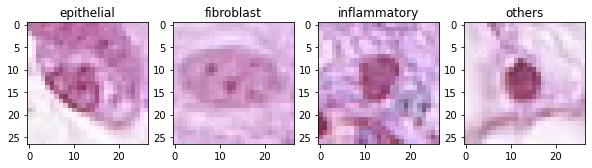

In [5]:
show_images(main_df)

Number of images for each cell type:


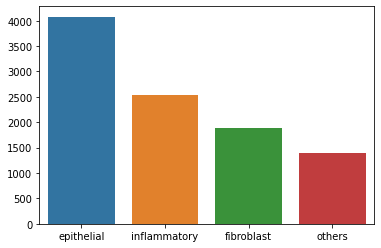

In [6]:
print("Number of images for each cell type:")

ax = sns.barplot(x=main_df["cellTypeName"].value_counts().index, y=main_df["cellTypeName"].value_counts().values, data=main_df)

The above bar plot, shows that the image classification model might do well for the epithelial cell type, as it contains close to 4000 images, double of fibroblast and others cell type.

Since this task, is to identify the images as cell type, we can remove the column IsCancerous, InstanceID and the patientID

In [7]:
main_df.drop(columns = ["isCancerous", "patientID", "InstanceID"], inplace=True)

In [8]:
main_df.head()

,ImageName,cellTypeName,cellType
0,22405.png,fibroblast,0
1,22406.png,fibroblast,0
2,22407.png,fibroblast,0
3,22408.png,fibroblast,0
4,22409.png,fibroblast,0


In [9]:
main_df.groupby("cellTypeName").first()

,ImageName,cellType
cellTypeName,,
epithelial,276.png,2
fibroblast,22405.png,0
inflammatory,22417.png,1
others,22423.png,3


As per the above table, "Fibroblast" is represented as 0, "Inflammatory" as 1, "Epithelial" as 2 and "others" as 3. Since we have cellType, there is no need for cellTypeName

In [10]:
main_df.drop(columns = ["cellTypeName"], inplace = True)

In [11]:
main_df.head()

,ImageName,cellType
0,22405.png,0
1,22406.png,0
2,22407.png,0
3,22408.png,0
4,22409.png,0


In [12]:
def add_path(image):
    return "./patch_images/"+image

main_df["ImageName"] = main_df["ImageName"].apply(add_path)

In [13]:
main_df.head()

,ImageName,cellType
0,./patch_images/22405.png,0
1,./patch_images/22406.png,0
2,./patch_images/22407.png,0
3,./patch_images/22408.png,0
4,./patch_images/22409.png,0


In [14]:
main_df.shape

(9896, 2)

Let's split the dataset into train, valid and test. For the training purpose, we will divide the data into 20% for test and 25% validation data out of total.

In [15]:
train_data, test_data = train_test_split(main_df, test_size=0.2, random_state=9)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=9)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


The size of the dataset after split, indicates high number of samples for the model to train on and equal number of samples for validation and testing task.

In [16]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [17]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 4

In [18]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'1.15.5'

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1120256   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 1,122,308
Trainable params: 1,122,308
Non-trainable params: 0
_________________________________________________________________


In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [22]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [23]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [25]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

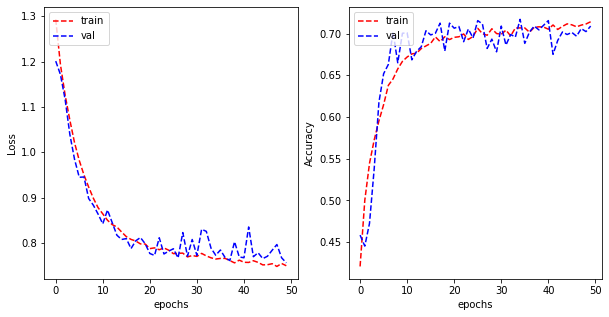

In [26]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [27]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [28]:
model.evaluate(test_generator)

1980/1980 [==============================] - 26s 13ms/step - loss: 0.7897 - categorical_accuracy: 0.6934


[0.789699866678454, 0.69343436]

In [29]:
label_names = {'Fibroblast' : 0, 'Inflammatory' : 1, 'Epithelial' : 2, 'others' : 3}

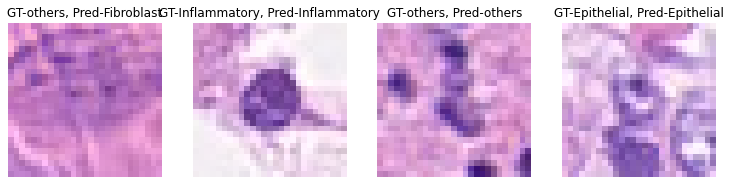

In [30]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [31]:
model.evaluate(train_generator)

186/186 [==============================] - 9s 50ms/step - loss: 0.7360 - categorical_accuracy: 0.7185


[0.7360112439560634, 0.7185447]

In [32]:
model.evaluate(validation_generator)

62/62 [==============================] - 3s 46ms/step - loss: 0.7558 - categorical_accuracy: 0.7089


[0.7558384898208803, 0.7089439]

## Deep Learning Model

Since we have created the train, test and validation data generator, we can use the same for the Deep Learning Models as well.

In [33]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [34]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [35]:
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

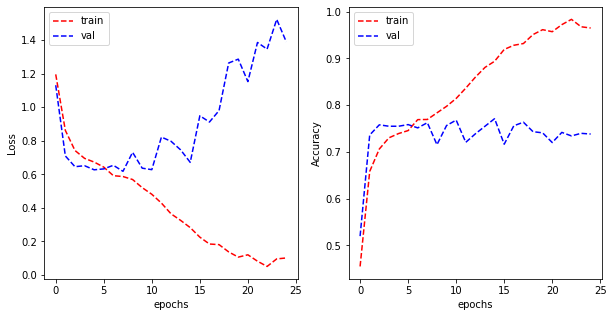

In [36]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [37]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [38]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

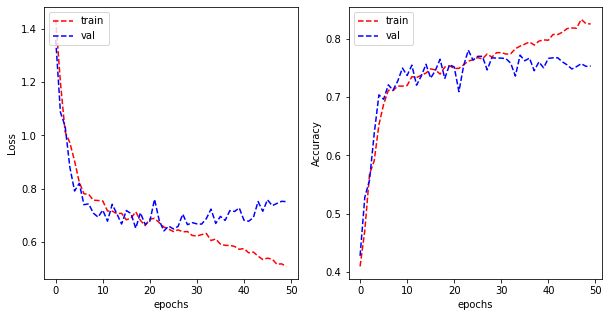

In [39]:
history_VGG_2 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [40]:
model.evaluate(test_generator)

1980/1980 [==============================] - 5s 3ms/step - loss: 0.7897 - categorical_accuracy: 0.6934


[0.789699866678454, 0.69343436]

In [41]:
model.evaluate(train_generator)

186/186 [==============================] - 2s 11ms/step - loss: 0.7360 - categorical_accuracy: 0.7185


[0.7359853670481713, 0.7185447]

In [42]:
model.evaluate(validation_generator)

62/62 [==============================] - 1s 11ms/step - loss: 0.7553 - categorical_accuracy: 0.7089


[0.7553262998980861, 0.7089439]